# OpenStreetMap SF Study
<hr><i>By: Praneetha Potiny</i>

This project cleans, analyzes, and discusses some of the OpenStreetMap data from a metro extract of San Francisco, CA. I'm hoping I'll provide interesting and/or useful information through this analysis. The link to the map and my reasons for choosing it are contained in 'osm-mapinfo.txt'.

<h2> Code Functionality</h2><hr>
<p>I have three functions in audit.py that I use to audit the open street map data. I dealt with the keys that I thought were the most problematic which were:</p>
<br>
<li>Phone Numbers</li>
<li>Street Address</li>
<li>Source</li>

<p> I also have other functions I use to query the database for statistics. All database querying was done using sqlite3</p>

In [1]:
import sqlite3
db = sqlite3.connect("SanFranciscoOSM.db")
cur = db.cursor()

<h2>Problematic Areas</h2><hr>
<h3>Phone Numbers</h3>
<br>
I came across a variety of formats for phone numbers. The first thing I wanted to do was put them all in the same format. Some phone numbers had letters so I included all alpha-numeric characters and placed them in the form of '+1-###-###-####'. I noticed that some numbers were missing digits or contained something other than a phone number (like a website). These were returned as None.

Some formats that I saw were:
<li>123-456-7890 (missing the country code)</li>
<li>1234567890 (missing dashes)</li>
<li>123-456-789 (missing last digit)</li>

Except for the last number, all of the above numbers would be formatted as '+1-123-456-7890'. The last number would return None.

<h3>Street Addresses</h3>
<br>
When auditing street addresses, I decided to focus on abbreviations, variations in capitilization, and punctuation. I did not translate cardinal directions, because there were streets that actually contained the single letter 'E' but did not translate to East. I knew this because there were other streets that started with single letters (e.g. - 'D Street').

Here are some examples of how they will be converted:
<li>E Street -- (E Street)</li>
<li>Upton St. -- ('Upton Street')</li>
<li>foothill blvd -- ('Foothill Boulevard')</li>
<li>Woodside Road, Suite 100 -- ('Woodside Road')</li>
<li>A st. & N blvd -- (('A Street', 'N Boulevard'))</li>

I removed numbers in the beginning and ending of street names, as well as the word 'suite' or 'ste'. I realized that most people did not put in their exact addresses. I reasoned that having generalized street names would make them easier to analyze as groups.
Also, if there were two addresses present, I would return them as a tuple.

In [2]:
good_street_names = {'rd': 'Road',
                     'plz': 'Plaza',
                     'blvd': 'Boulevard',
                     'ave': 'Avenue',
                     'st': 'Street',
                     'hwy': 'Highway',
                     'ctr': 'Center',
                     'dr': 'Drive'}

<h3>Source</h3>
<br>
The sources for each node refer to the source of information for a specific node. Many of the sources were very specific. In order to be able to group each source into a category, I glanced through the unique sources and came up with a list of the most common sources by their most simplistic names. I also did the same with websites, by making it less specific.

All sources that were not converted stay exactly as they are.

Here are some examples of how they will be converted:
<li>Field Observation -- ('observation')</li>
<li>Google; Yahoo -- (('google', 'yahoo')) </li>
<li>NPS map -- ('map')</li>
<li>http://www.dot.ca.gov/ ... /101.pdf -- ('http://www.dot/ca/gov/')</li>
<li>Street View -- ('Street View')</li> 

<i>Note</i>: The '...' in the 4th bullet was used for convenience and is not actually what is written


In [3]:
common_sources = ['bing', 'yahoo', 'google', 'survey', 'map', 'observation',
                  'knowledge', 'gps', 'yelp', 'website', 'gtfs', 'usgs']

common_webs = ['dot.ca.gov', 'yelp.com/biz']

<h2>Statistics</h2>

### File Size

<i>San Francisco OSM -- 400.722 MB</i>

### Number of Nodes

In [4]:
cur.execute("SELECT COUNT(*) FROM nodes")
for c in cur: print c[0]

4533476


### Number of Ways

In [5]:
cur.execute("SELECT COUNT(*) FROM ways")
for c in cur: print c[0]

524685


### Top 10 keys for Nodes

In [6]:
cur.execute("""
            SELECT k, COUNT(*) FROM nodes_tags 
            GROUP BY k 
            ORDER BY COUNT(*) DESC 
            LIMIT 10
                    """)
for c in cur: print c[1], '|', c[0]

24660 | addr:housenumber
23279 | highway
22115 | addr:street
18205 | addr:city
16964 | name
12994 | created_by
12634 | amenity
7807 | source
7503 | addr:postcode
6386 | addr:state


### Top 10 keys for Ways

In [7]:
cur.execute("""
            SELECT k, COUNT(*) FROM ways_tags 
            GROUP BY k 
            ORDER BY COUNT(*) DESC 
            LIMIT 10
                    """)

for c in cur: print c[1], '|', c[0]

397148 | building
95714 | highway
68736 | name
54283 | source
52702 | tiger:county
51493 | tiger:cfcc
49029 | tiger:name_base
46095 | tiger:name_type
44556 | height
40008 | tiger:zip_left


### Number of unique keys

In [8]:
cur.execute("""
            SELECT COUNT(*) FROM
            (SELECT DISTINCT(k) FROM
            (SELECT k from nodes_tags
            UNION ALL
            SELECT k from ways_tags))
                            """)
for c in cur: print c[0]

1379


### Top 10 Cities

In [9]:
import osm_main

osm_main.top_percent(cur, 'addr:city')

41.44% | Redwood City
30.28% | San Francisco
9.90% | Berkeley
6.71% | Piedmont
2.89% | Palo Alto
2.38% | Richmond
2.36% | Oakland
0.46% | Union City
0.39% | Albany
0.35% | Burlingame


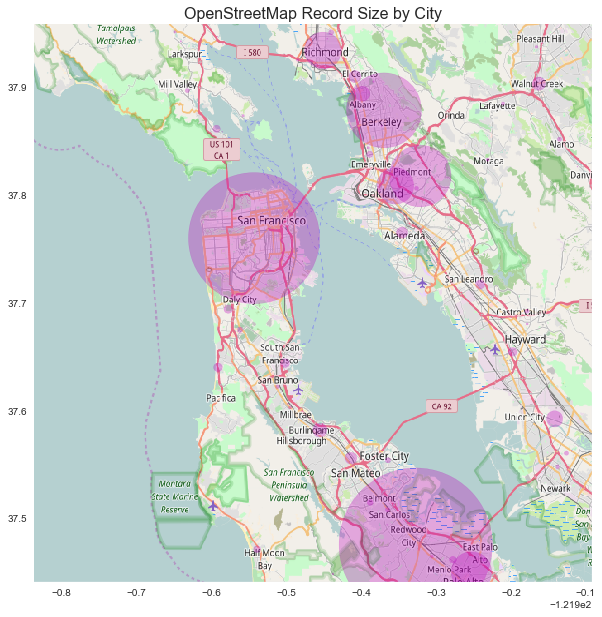

In [10]:
import osm_plot

%matplotlib inline

osm_plot.scatter_map(db, 'sfmap.png', 'OpenStreetMap Record Size by City')

### <i>Redwood City?</i>

As we can see from the map image above, the data mostly covers five cities in the map. Redwood City is pretty far from San Francisco, yet 41.44% of the data is related to Redwood City. Perhaps users in this city filled out most of this region of the map.

<h2>Additional Statistics</h2>
<hr>
### Top 10 fast food cuisines for nodes

In [11]:
cur.execute("""SELECT v, COUNT(*) FROM nodes_tags WHERE id IN
                (SELECT id FROM nodes_tags
                WHERE k='amenity' AND v='fast_food')
                AND k='cuisine'
                GROUP BY v
                ORDER BY COUNT(*) DESC
                LIMIT 10""")

for c in cur:
    print c[1], "|", c[0]

68 | burger
60 | sandwich
39 | mexican
39 | pizza
16 | chicken
14 | ice_cream
7 | bagel
7 | chinese
6 | american
4 | juice


### The 3 most popular kinds of shops

In [12]:
osm_main.top_v(cur, 'shop', count=3)

331 | convenience
326 | clothes
309 | hairdresser


### Biggest Coffee Shop Chain

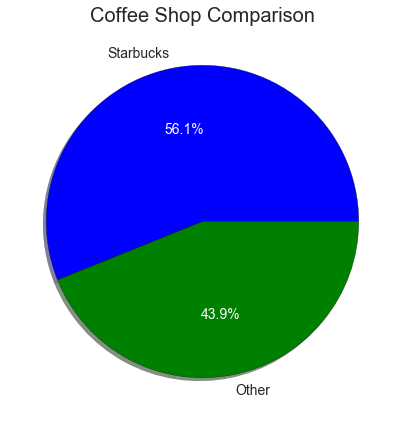

In [13]:
cur.execute("""SELECT v, COUNT(*) FROM nodes_tags WHERE id IN
                (SELECT id FROM nodes_tags
                WHERE k='amenity' AND v='cafe')
                AND k='name'
                GROUP BY v
                ORDER BY COUNT(*) DESC""")

coffee_shops = {c[1]:c[0] for c in cur}

other = -max(coffee_shops)
for shop in coffee_shops:
    other += shop
    
%matplotlib inline

osm_plot.value_pies([max(coffee_shops), other], [coffee_shops[max(coffee_shops)], 'Other'], "Coffee Shop Comparison")

### Unsurprisingly, it's Starbucks
I didn't audit this particular set of data. However, it is clear to see that Starbucks is the major coffee shop in the data.

<h2>Suggestions</h2>
<hr>
#### What I saw:
<li> 199 shops with the value: 'yes' </li>
<li> Most of the data is from Redwood City and San Francisco</li>

#### 1) Source from a Website
There were entries that either lacked information or contained incorrect information. As an example of incorrect information, I saw a lot of entries with 'yes' in the 'shop' category. I think it should be mandatory to cite a valid website as the source of information. This means that users must put a safe and working link to a website that contains information specific to the element. This will make it easier to organize sources and prevent incorrect values.

The problem with doing this is that there are many businesses that do not have their information on websites. Their existence would be lost to us. If websites were not required, users that visited the business could input whatever information that they do know. There's still the possibility that this information is correct. 

There's also the problem of not being able to assess the validity or correctness of the information from sites that they choose. For example, it may be acceptable to put "yes" as the value for a phone-number in the site that they are using. However, if OpenStreetMap chooses to limit the websites that they can source from, then users would have less businesses to input. In fact, they may be discouraged from doing so because they have limited resources.

<br>
#### 2) Cities on the Front Page
I also think that OpenStreetMap should list cities that need more information on their homepage. One way to do this, would be to randomly select ten cities that don't contain enough information. Each week, this selection would change so that each city gets a chance and users won't feel overwhelmed by the amount of data needed. Users that are familiar with these cities might be tempted to input data.

The problem with doing this is that certain cities are not as populated or as well-known as others. I noticed that many cities in the United States are available as metro extracts. If I were to assume that OpenStreetMap users are mostly American, then that means cities outside of the United States would probably be less well-known than American cities. Therefore, users would not be tempted into finding data about these cities.

While there is a possibility that the user will come across a city they know, the chances of that happening during a specific week are low.

<h2>Conclusion</h2>
<hr>
The area is fairly large, so it wasn't surprising to see a variety of cities on the map. Although I was surprised to see that Redwood City had the largest number of records. Overall, I believe cleaning the dataset did make it easier to analyze the phone numbers, streets, and sources, because we can group more of the values together. I did suggest that users should be required to source from websites and be made aware of cities that need more information. However, in order to make those suggestions better, I would need to research user interaction with OpenStreetMap and the validity of non-website sources. Hopefully, more of the map will be filled out in the future. When that happens, I'd like to analyze the data again to see how much it's changed.